In [1]:
import os
from PIL import Image
import numpy as np
from keras.layers import Input, Convolution2D, merge, Dense, Dropout, Flatten, Conv2D, MaxPooling3D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import math
from skimage.io import imread
from matplotlib import pyplot as plt
import sklearn.feature_extraction
import sklearn.feature_selection as t
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
import scipy.ndimage.filters
import random

Using TensorFlow backend.


In [2]:
def PSNR(y_true, y_pred):
    return 10.0 * K.log(1 / (K.mean(K.square(y_pred - y_true)))) / K.log(10.0)

In [3]:
def threecompare(in_im, out_im, pred_im):
    img1 = (out_im*255).reshape(img_rows, img_cols)
    img2 = (in_im*255).reshape(img_rows, img_cols)
    kernel = np.ones((3,3))*(-1)
    kernel[1,1] = 8
    lap = scipy.ndimage.filters.convolve((in_im*255).reshape(img_rows, img_cols), kernel)
    laps = lap*100.0/np.amax(lap)
    img3 = ((in_im*255).reshape(img_rows, img_cols) + laps/10).reshape(img_rows, img_cols)
    img4 = (pred_im*255).reshape(img_rows, img_cols)
    label = 'SSIM: {:.2f}'
    ssim1 = ssim(img1, img1, data_range=img1.max() - img1.min())
    ssim2 = ssim(img1, img2, data_range=img2.max() - img2.min())
    ssim3 = ssim(img1, img3, data_range=img3.max() - img3.min())
    ssim4 = ssim(img1, img4, data_range=img4.max() - img4.min())
    print('Original image')
    print(label.format(ssim1))
    print('\n'+'Bicubic image')
    print(label.format(ssim2))
    print('\n'+'Bicubic with laplasian image')
    print(label.format(ssim3))
    print('\n'+'Produced image')
    print(label.format(ssim4))

In [4]:
def imload(d, mode, channels, img_rows, img_cols):
    directory = '../Картинки/'+d
    files = os.listdir(directory)
    flag = True
    i = 0
    while flag and i < len(files):
        if files[i] == '.DS_Store':
            del files[i]
            flag = False
        i+= 1
    num = 0
    for name in range(len(files)):
        im = Image.open(directory+'/'+ files[name]).convert('L')
        width, height = im.size
        num += (width//img_rows)*(height//img_cols)
    num = num*4
    x = np.zeros((num, img_rows, img_cols, channels))
    y = np.zeros((num, img_rows, img_cols, channels))
    num1 = np.zeros((num))
    num = 0
    for name in range(len(files)):
        I = Image.open(directory+'/'+ files[name]).convert('L')
        width1, height1 = I.size
        if (width1//img_rows > 1) and (height1//img_cols > 1):
            for i in range(width1//img_rows):
                for j in range(height1//img_cols):
                    im = I.crop((i*img_rows, j*img_cols, (i+1)*img_rows, (j+1)*img_cols))
                    width, height = im.size
                    for k in range(4):
                        im_ = im.rotate(90*k)
                        a = np.asarray(im_).astype('float32')
                        im1 = im_.resize((int(width/2), int(height/2)))
                        im1 = im1.resize((width, height), Image.BICUBIC)
                        a1 = np.asarray(im1).astype('float32')
                        a = a.reshape(img_rows, img_cols, channels)
                        a1 = a1.reshape(img_rows, img_cols, channels)
                        flag = True
                        while flag:
                            e = random.randint(0, len(num1)-1)
                            if num1[e] != 1:
                                flag = False
                        num1[e] = 1
                        x[e] = a1
                        y[e] = a
        elif width1//img_rows > 1:
            for i in range(width1//img_rows):
                im = I.crop((i*img_rows, 0, (i+1)*img_rows, img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        elif height1//img_cols > 1:
            for j in range(height1//img_cols):
                im = I.crop((0, j*img_cols, img_rows, (j+1)*img_cols))
                width, height = im.size
                for k in range(4):
                    im_ = im.rotate(90*k)
                    a = np.asarray(im_).astype('float32')
                    im1 = im_.resize((int(width/2), int(height/2)))
                    im1 = im1.resize((width, height), Image.BICUBIC)
                    a1 = np.asarray(im1).astype('float32')
                    a = a.reshape(img_rows, img_cols, channels)
                    a1 = a1.reshape(img_rows, img_cols, channels)
                    flag = True
                    while flag:
                        e = random.randint(0, len(num1)-1)
                        if num1[e] != 1:
                            flag = False
                    num1[e] = 1
                    x[num] = a1
                    y[num] = a
                    num += 1
        else:
            im = I.crop((0,0,img_rows, img_cols))
            width, height = im.size
            for k in range(4):
                im_ = im.rotate(90*k)
                a = np.asarray(im_).astype('float32')
                im1 = im_.resize((int(width/2), int(height/2)))
                im1 = im1.resize((width, height), Image.BICUBIC)
                a1 = np.asarray(im1).astype('float32')
                a = a.reshape(img_rows, img_cols, channels)
                a1 = a1.reshape(img_rows, img_cols, channels)
                flag = True
                while flag:
                    e = random.randint(0, len(num1)-1)
                    if num1[e] != 1:
                        flag = False
                num1[e] = 1
                x[num] = a1
                y[num] = a
                num += 1
    return x, y

In [5]:
def preprocess(x, y, channels, img_rows, img_cols):
    x /= 255
    y /= 255
    x = x.astype('float32')
    y = y.astype('float32')
    x = x.reshape(x.shape[0], img_rows, img_cols, channels)
    y = y.reshape(y.shape[0], img_rows, img_cols, channels)
    return x, y

In [6]:
def getim(im):
    im1 = Image.new('L', (im.shape[0],im.shape[1]))
    p = im1.load()
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if int(im[i][j]) > 255:
                p[i,j] = 255
            elif int(im[i][j]) < 0:
                p[i,j] = 0
            else:
                p[i,j] = int(im[i][j])
    return im1

In [7]:
def results(x, y, p, img_rows, img_cols, f):
    PSNR_bicubic = 0
    PSNR_laplasian = 0
    PSNR_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        lap = scipy.ndimage.filters.convolve(im1.reshape(img_rows, img_cols), kernel)
        laps = lap*100.0/np.amax(lap)
        im2 = y[i]*255
        im3 = p[i]*255
        im4 = (im1.reshape(img_rows, img_cols) + laps/10)
        answer1 = getim(im1)
        answer1.save('model 1-3/original/'+f+'/image '+str(i)+' bicubic.png','png')
        answer2 = getim(im2)
        answer2.save('model 1-3/original/'+f+'/image '+str(i)+' original.png','png')
        answer3 = getim(im3)
        answer3.save('model 1-3/original/'+f+'/image '+str(i)+' worked.png','png')
        answer4 = getim(im4)
        answer4.save('model 1-3/original/'+f+'/image '+str(i)+' with laplasian.png','png')
        PSNR_bicubic += 10.0 * np.log(255*255 / (np.mean(np.square(im1.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)
        PSNR_laplasian += 10.0 * np.log(255*255 / (np.mean(np.square(im4.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)
        PSNR_model += 10.0 * np.log(255*255 / (np.mean(np.square(im3.reshape(img_rows, img_cols) - im2.reshape(img_rows, img_cols))))) / np.log(10.0)    
    print('Bicubic PSNR:', PSNR_bicubic/len(x))
    print('Laplasian PSNR:', PSNR_laplasian/len(x))
    print('Model PSNR:', PSNR_model/len(x))

In [8]:
def ressim(x, y, p, img_rows, img_cols):
    SSIM_bicubic = 0
    SSIM_laplasian = 0
    SSIM_model = 0
    for i in range(len(x)):
        im1 = x[i]*255
        kernel = np.ones((3,3))*(-1)
        kernel[1,1] = 8
        lap = scipy.ndimage.filters.convolve(im1.reshape(img_rows, img_cols), kernel)
        laps = lap*100.0/np.amax(lap)
        im4 = (im1.reshape(img_rows, img_cols) + laps/10)
        im2 = y[i]*255
        im3 = p[i]*255
        SSIM_bicubic += ssim(im1.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im1.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
        SSIM_laplasian += ssim(im4.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im4.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
        SSIM_model += ssim(im3.reshape(img_rows, img_cols), im2.reshape(img_rows, img_cols), data_range=im3.reshape(img_rows, img_cols).max() - im2.reshape(img_rows, img_cols).min())
    print('Bicubic SSIM:', SSIM_bicubic/len(x))
    print('Laplasian SSIM:', SSIM_laplasian/len(x))
    print('Model SSIM:', SSIM_model/len(x))

In [9]:
img_rows, img_cols = 100, 100
mode = 'L'
channels = 1

In [10]:
batch_size = 15
nb_epoch = 2500
n1 = 1
f1 = 3

In [11]:
X_train, Y_train = imload('Train/Train_first', mode, channels, img_rows, img_cols)
X_test, Y_test = imload('Test/Test_first', mode, channels, img_rows, img_cols)
X_test5, Y_test5 = imload('Test/Set5', mode, channels, img_rows, img_cols)
X_test14, Y_test14 = imload('Test/Set14', mode, channels, img_rows, img_cols)
X_valid, Y_valid = imload('Validation/Validation_first', mode, channels, img_rows, img_cols)

In [12]:
in_train, out_train = preprocess(X_train, Y_train, channels, img_rows, img_cols)
in_test, out_test = preprocess(X_test, Y_test, channels, img_rows, img_cols)
in_test5, out_test5 = preprocess(X_test5, Y_test5, channels, img_rows, img_cols)
in_test14, out_test14 = preprocess(X_test14, Y_test14, channels, img_rows, img_cols)
in_valid, out_valid = preprocess(X_valid, Y_valid, channels, img_rows, img_cols)

In [13]:
input_shape = (img_rows, img_cols, channels)
model = Sequential()
model.add(Conv2D(n1, (f1, f1), input_shape=input_shape, name='output', padding="same")) 
model.compile(loss="mse", optimizer="adam", metrics=[PSNR])

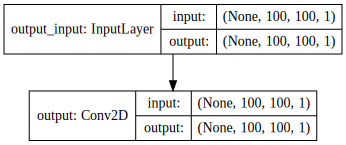

In [14]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
history = model.fit(in_train, out_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(in_valid, out_valid))

Train on 1224 samples, validate on 176 samples
Epoch 1/2500
1224/1224 [==============================] - 3s 2ms/step - loss: 0.0508 - PSNR: 13.9496 - val_loss: 0.0179 - val_PSNR: 17.8824
Epoch 2/2500
1224/1224 [==============================] - 3s 2ms/step - loss: 0.0120 - PSNR: 19.2876 - val_loss: 0.0142 - val_PSNR: 18.9756
Epoch 3/2500
1224/1224 [==============================] - 3s 2ms/step - loss: 0.0110 - PSNR: 19.6839 - val_loss: 0.0134 - val_PSNR: 19.2616
Epoch 4/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0103 - PSNR: 19.9747 - val_loss: 0.0127 - val_PSNR: 19.5406
Epoch 5/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0097 - PSNR: 20.2628 - val_loss: 0.0120 - val_PSNR: 19.80620.0097 - PSNR: 20.26
Epoch 6/2500
1224/1224 [==============================] - 3s 2ms/step - loss: 0.0091 - PSNR: 20.5149 - val_loss: 0.0113 - val_PSNR: 20.0631
Epoch 7/2500
1224/1224 [==============================] - 3s 2ms/step - loss: 0.0086 - PSNR: 

1224/1224 [==============================] - 9s 8ms/step - loss: 0.0016 - PSNR: 28.3557 - val_loss: 0.0017 - val_PSNR: 27.9976
Epoch 59/2500
1224/1224 [==============================] - 9s 7ms/step - loss: 0.0016 - PSNR: 28.2923 - val_loss: 0.0017 - val_PSNR: 28.0039
Epoch 60/2500
1224/1224 [==============================] - 7s 6ms/step - loss: 0.0016 - PSNR: 28.3434 - val_loss: 0.0017 - val_PSNR: 28.0105
Epoch 61/2500
1224/1224 [==============================] - 8s 7ms/step - loss: 0.0016 - PSNR: 28.2445 - val_loss: 0.0017 - val_PSNR: 28.0152
Epoch 62/2500
1224/1224 [==============================] - 10s 8ms/step - loss: 0.0016 - PSNR: 28.3420 - val_loss: 0.0017 - val_PSNR: 28.02020.0016 - PSNR: 2
Epoch 63/2500
1224/1224 [==============================] - 9s 8ms/step - loss: 0.0016 - PSNR: 28.3024 - val_loss: 0.0017 - val_PSNR: 28.0248
Epoch 64/2500
1224/1224 [==============================] - 10s 9ms/step - loss: 0.0016 - PSNR: 28.4124 - val_loss: 0.0017 - val_PSNR: 28.0293
Epoch 65/

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4009 - val_loss: 0.0017 - val_PSNR: 28.1211
Epoch 116/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3697 - val_loss: 0.0017 - val_PSNR: 28.1229
Epoch 117/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3681 - val_loss: 0.0017 - val_PSNR: 28.1238
Epoch 118/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3798 - val_loss: 0.0017 - val_PSNR: 28.1243
Epoch 119/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4611 - val_loss: 0.0017 - val_PSNR: 28.1221
Epoch 120/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3643 - val_loss: 0.0017 - val_PSNR: 28.1253
Epoch 121/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4595 - val_loss: 0.0017 - val_PSNR: 28.1263
Epoch 122/2500
1224/1

Epoch 173/2500
1224/1224 [==============================] - 4s 4ms/step - loss: 0.0015 - PSNR: 28.3852 - val_loss: 0.0017 - val_PSNR: 28.1451
Epoch 174/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4104 - val_loss: 0.0017 - val_PSNR: 28.1475
Epoch 175/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3658 - val_loss: 0.0017 - val_PSNR: 28.1470
Epoch 176/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4639 - val_loss: 0.0017 - val_PSNR: 28.1475
Epoch 177/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4056 - val_loss: 0.0017 - val_PSNR: 28.1447
Epoch 178/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4690 - val_loss: 0.0017 - val_PSNR: 28.1459
Epoch 179/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4710 - val_loss: 0.0017 - val_PSNR: 28.1452
Epoch 

Epoch 231/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4514 - val_loss: 0.0017 - val_PSNR: 28.1531
Epoch 232/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4163 - val_loss: 0.0017 - val_PSNR: 28.1532
Epoch 233/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4602 - val_loss: 0.0017 - val_PSNR: 28.1534
Epoch 234/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4379 - val_loss: 0.0017 - val_PSNR: 28.1530
Epoch 235/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4255 - val_loss: 0.0017 - val_PSNR: 28.1542
Epoch 236/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4507 - val_loss: 0.0017 - val_PSNR: 28.1551
Epoch 237/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4566 - val_loss: 0.0017 - val_PSNR: 28.1511
Epoch 

Epoch 289/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5738 - val_loss: 0.0017 - val_PSNR: 28.1562
Epoch 290/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4754 - val_loss: 0.0017 - val_PSNR: 28.1575
Epoch 291/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3797 - val_loss: 0.0017 - val_PSNR: 28.1552
Epoch 292/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4459 - val_loss: 0.0017 - val_PSNR: 28.1466
Epoch 293/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4340 - val_loss: 0.0017 - val_PSNR: 28.1576
Epoch 294/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4490 - val_loss: 0.0017 - val_PSNR: 28.1564
Epoch 295/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5509 - val_loss: 0.0017 - val_PSNR: 28.1562
Epoch 

Epoch 346/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4351 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 347/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4703 - val_loss: 0.0017 - val_PSNR: 28.1538
Epoch 348/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4555 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 349/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5325 - val_loss: 0.0017 - val_PSNR: 28.1589
Epoch 350/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5054 - val_loss: 0.0017 - val_PSNR: 28.1589
Epoch 351/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4882 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 352/2500
1224/1224 [==============================] - 4s 4ms/step - loss: 0.0015 - PSNR: 28.4727 - val_loss: 0.0017 - val_PSNR: 28.1548
Epoch 

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4206 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 404/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4278 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 405/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4681 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 406/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4598 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 407/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4510 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 408/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4677 - val_loss: 0.0017 - val_PSNR: 28.1601
Epoch 409/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4881 - val_loss: 0.0017 - val_PSNR: 28.1544
Epoch 410/2500
1224/1

1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4336 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 461/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4530 - val_loss: 0.0017 - val_PSNR: 28.1592
Epoch 462/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4303 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 463/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0015 - PSNR: 28.4311 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 464/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0015 - PSNR: 28.4258 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 465/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4430 - val_loss: 0.0017 - val_PSNR: 28.1605A: 1s - loss
Epoch 466/2500
1224/1224 [==============================] - 6s 5ms/step - loss: 0.0015 - PSNR: 28.4951 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 467

1224/1224 [==============================] - 4s 4ms/step - loss: 0.0015 - PSNR: 28.4940 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 518/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4894 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 519/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4710 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 520/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4874 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 521/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4518 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 522/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5167 - val_loss: 0.0017 - val_PSNR: 28.1592
Epoch 523/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4448 - val_loss: 0.0017 - val_PSNR: 28.1545
Epoch 524/2500
1224/1

Epoch 575/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4465 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 576/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4565 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 577/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4687 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 578/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4402 - val_loss: 0.0017 - val_PSNR: 28.1581
Epoch 579/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4386 - val_loss: 0.0017 - val_PSNR: 28.1589
Epoch 580/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5388 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 581/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4419 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 

Epoch 633/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4142 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 634/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3792 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 635/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4916 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 636/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4616 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 637/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4595 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 638/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.5042 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 639/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4275 - val_loss: 0.0017 - val_PSNR: 28.1619
Epoch 

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4878 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 691/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4331 - val_loss: 0.0017 - val_PSNR: 28.1601
Epoch 692/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4707 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 693/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4912 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 694/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4863 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 695/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4940 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 696/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5934 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 697/2500
1224/1

Epoch 748/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4562 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 749/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5411 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 750/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4512 - val_loss: 0.0017 - val_PSNR: 28.1619
Epoch 751/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5025 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 752/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4810 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 753/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5585 - val_loss: 0.0017 - val_PSNR: 28.1580
Epoch 754/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4353 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4965 - val_loss: 0.0017 - val_PSNR: 28.1587
Epoch 806/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4675 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 807/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4980 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 808/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4899 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 809/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4105 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 810/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4435 - val_loss: 0.0017 - val_PSNR: 28.1595
Epoch 811/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4234 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 812/2500
1224/1

Epoch 863/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4911 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 864/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4902 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 865/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4472 - val_loss: 0.0017 - val_PSNR: 28.1586
Epoch 866/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4442 - val_loss: 0.0017 - val_PSNR: 28.1627
Epoch 867/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4270 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 868/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4159 - val_loss: 0.0017 - val_PSNR: 28.1589
Epoch 869/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4744 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 

Epoch 921/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4879 - val_loss: 0.0017 - val_PSNR: 28.1602
Epoch 922/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4406 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 923/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4769 - val_loss: 0.0017 - val_PSNR: 28.1597
Epoch 924/2500
1224/1224 [==============================] - 4s 4ms/step - loss: 0.0015 - PSNR: 28.4019 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 925/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5087 - val_loss: 0.0017 - val_PSNR: 28.1551
Epoch 926/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4815 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 927/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5065 - val_loss: 0.0017 - val_PSNR: 28.1601
Epoch 

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5097 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 979/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4003 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 980/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4746 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 981/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4590 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 982/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4700 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 983/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4511 - val_loss: 0.0017 - val_PSNR: 28.1576
Epoch 984/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4982 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 985/2500
1224/1

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5055 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1036/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4818 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 1037/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4426 - val_loss: 0.0017 - val_PSNR: 28.1573
Epoch 1038/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4275 - val_loss: 0.0017 - val_PSNR: 28.1574
Epoch 1039/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4837 - val_loss: 0.0017 - val_PSNR: 28.1592
Epoch 1040/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4346 - val_loss: 0.0017 - val_PSNR: 28.1580
Epoch 1041/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4987 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 1042/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4409 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 1093/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4907 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 1094/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4195 - val_loss: 0.0017 - val_PSNR: 28.1623
Epoch 1095/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4236 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1096/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4380 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1097/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4298 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 1098/2500
1224/1224 [==============================] - 5s 4ms/step - loss: 0.0015 - PSNR: 28.4067 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1099/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4540 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 1150/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4951 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 1151/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5280 - val_loss: 0.0017 - val_PSNR: 28.1578
Epoch 1152/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4087 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 1153/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4333 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 1154/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4882 - val_loss: 0.0017 - val_PSNR: 28.1587
Epoch 1155/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4280 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1156/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4764 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 1207/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4216 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 1208/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4261 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 1209/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4581 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 1210/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3771 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 1211/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4922 - val_loss: 0.0017 - val_PSNR: 28.1527
Epoch 1212/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4676 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 1213/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4119 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1264/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4660 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1265/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4778 - val_loss: 0.0017 - val_PSNR: 28.1519
Epoch 1266/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4420 - val_loss: 0.0017 - val_PSNR: 28.1587
Epoch 1267/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4224 - val_loss: 0.0017 - val_PSNR: 28.1541
Epoch 1268/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4512 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 1269/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4076 - val_loss: 0.0017 - val_PSNR: 28.1597
Epoch 1270/2500

Epoch 1320/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3989 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1321/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4498 - val_loss: 0.0017 - val_PSNR: 28.1554
Epoch 1322/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4903 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 1323/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3904 - val_loss: 0.0017 - val_PSNR: 28.1619
Epoch 1324/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4588 - val_loss: 0.0017 - val_PSNR: 28.1565
Epoch 1325/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4402 - val_loss: 0.0017 - val_PSNR: 28.1525
Epoch 1326/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4137 - val_loss: 0.0017 - val_PSNR: 28.1614

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4917 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 1378/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4915 - val_loss: 0.0017 - val_PSNR: 28.1577
Epoch 1379/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4620 - val_loss: 0.0017 - val_PSNR: 28.1580
Epoch 1380/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4573 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 1381/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4701 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1382/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4348 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 1383/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4545 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 1384/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4096 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 1435/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4207 - val_loss: 0.0017 - val_PSNR: 28.1578
Epoch 1436/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3952 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 1437/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4558 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 1438/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4965 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 1439/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4578 - val_loss: 0.0017 - val_PSNR: 28.1526
Epoch 1440/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4818 - val_loss: 0.0017 - val_PSNR: 28.1599
Epoch 1441/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4352 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1492/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4785 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 1493/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5309 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 1494/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4148 - val_loss: 0.0017 - val_PSNR: 28.1554
Epoch 1495/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5012 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 1496/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5407 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 1497/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4258 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 1498/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4734 - val_loss: 0.0017 - val_PSNR: 28.1570
Epoch 1549/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4539 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1550/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4909 - val_loss: 0.0017 - val_PSNR: 28.1601
Epoch 1551/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5245 - val_loss: 0.0017 - val_PSNR: 28.1610ss: 0.
Epoch 1552/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4722 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 1553/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4525 - val_loss: 0.0017 - val_PSNR: 28.1596
Epoch 1554/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4607 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 155

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4867 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 1606/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5389 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 1607/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4592 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 1608/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4891 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1609/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4258 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 1610/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4572 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1611/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4422 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 1612/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4386 - val_loss: 0.0017 - val_PSNR: 28.1558
Epoch 1663/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4633 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 1664/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4640 - val_loss: 0.0017 - val_PSNR: 28.1587
Epoch 1665/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4358 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1666/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4915 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 1667/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4123 - val_loss: 0.0017 - val_PSNR: 28.1597
Epoch 1668/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5064 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 1669/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5836 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 1720/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3885 - val_loss: 0.0017 - val_PSNR: 28.1588
Epoch 1721/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4293 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1722/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4865 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 1723/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4997 - val_loss: 0.0017 - val_PSNR: 28.1518
Epoch 1724/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4390 - val_loss: 0.0017 - val_PSNR: 28.1601
Epoch 1725/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4799 - val_loss: 0.0017 - val_PSNR: 28.1582
Epoch 1726/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4333 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 1777/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4378 - val_loss: 0.0017 - val_PSNR: 28.1609
Epoch 1778/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4521 - val_loss: 0.0017 - val_PSNR: 28.1582
Epoch 1779/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3786 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 1780/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4186 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 1781/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3642 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 1782/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4391 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1783/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4792 - val_loss: 0.0017 - val_PSNR: 28.1599
Epoch 1834/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5257 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 1835/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4933 - val_loss: 0.0017 - val_PSNR: 28.1600
Epoch 1836/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3872 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1837/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4488 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 1838/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4360 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 1839/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4760 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 1840/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4077 - val_loss: 0.0017 - val_PSNR: 28.1588
Epoch 1891/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.3890 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 1892/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5093 - val_loss: 0.0017 - val_PSNR: 28.1605
Epoch 1893/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4502 - val_loss: 0.0017 - val_PSNR: 28.1591
Epoch 1894/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4677 - val_loss: 0.0017 - val_PSNR: 28.1620
Epoch 1895/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4530 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 1896/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.5271 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 1897/2500

1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4328 - val_loss: 0.0017 - val_PSNR: 28.1602
Epoch 1948/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4257 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1949/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4441 - val_loss: 0.0017 - val_PSNR: 28.1475
Epoch 1950/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4836 - val_loss: 0.0017 - val_PSNR: 28.1594
Epoch 1951/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4765 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 1952/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4663 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 1953/2500
1224/1224 [==============================] - 4s 3ms/step - loss: 0.0015 - PSNR: 28.4715 - val_loss: 0.0017 - val_PSNR: 28.1624
Epoch 1954/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4543 - val_loss: 0.0017 - val_PSNR: 28.1580
Epoch 2005/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4799 - val_loss: 0.0017 - val_PSNR: 28.1585
Epoch 2006/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5401 - val_loss: 0.0017 - val_PSNR: 28.1597
Epoch 2007/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5205 - val_loss: 0.0017 - val_PSNR: 28.1588
Epoch 2008/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5056 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 2009/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3888 - val_loss: 0.0017 - val_PSNR: 28.1602
Epoch 2010/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4891 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 2011/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5024 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 2062/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4452 - val_loss: 0.0017 - val_PSNR: 28.1510
Epoch 2063/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4597 - val_loss: 0.0017 - val_PSNR: 28.1555
Epoch 2064/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4918 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 2065/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4898 - val_loss: 0.0017 - val_PSNR: 28.1583
Epoch 2066/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3967 - val_loss: 0.0017 - val_PSNR: 28.1577
Epoch 2067/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4559 - val_loss: 0.0017 - val_PSNR: 28.1615
Epoch 2068/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4007 - val_loss: 0.0017 - val_PSNR: 28.1593
Epoch 2119/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4302 - val_loss: 0.0017 - val_PSNR: 28.1586
Epoch 2120/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4540 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 2121/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4775 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2122/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4732 - val_loss: 0.0017 - val_PSNR: 28.1603
Epoch 2123/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3840 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 2124/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4177 - val_loss: 0.0017 - val_PSNR: 28.1599
Epoch 2125/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4768 - val_loss: 0.0017 - val_PSNR: 28.1611
Epoch 2176/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4378 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 2177/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4270 - val_loss: 0.0017 - val_PSNR: 28.1479
Epoch 2178/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4955 - val_loss: 0.0017 - val_PSNR: 28.1590
Epoch 2179/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4839 - val_loss: 0.0017 - val_PSNR: 28.1590
Epoch 2180/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4959 - val_loss: 0.0017 - val_PSNR: 28.1617
Epoch 2181/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4329 - val_loss: 0.0017 - val_PSNR: 28.1591
Epoch 2182/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4909 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 2233/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4015 - val_loss: 0.0017 - val_PSNR: 28.1568
Epoch 2234/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4524 - val_loss: 0.0017 - val_PSNR: 28.1614
Epoch 2235/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4769 - val_loss: 0.0017 - val_PSNR: 28.1555
Epoch 2236/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3920 - val_loss: 0.0017 - val_PSNR: 28.1598
Epoch 2237/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4742 - val_loss: 0.0017 - val_PSNR: 28.1612
Epoch 2238/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5118 - val_loss: 0.0017 - val_PSNR: 28.1569
Epoch 2239/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4313 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2290/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5052 - val_loss: 0.0017 - val_PSNR: 28.1608
Epoch 2291/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4749 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 2292/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4010 - val_loss: 0.0017 - val_PSNR: 28.1577
Epoch 2293/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4670 - val_loss: 0.0017 - val_PSNR: 28.1563
Epoch 2294/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4381 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2295/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4919 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2296/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4628 - val_loss: 0.0017 - val_PSNR: 28.1613
Epoch 2347/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4497 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2348/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4133 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2349/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4582 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 2350/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4041 - val_loss: 0.0017 - val_PSNR: 28.1610
Epoch 2351/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4157 - val_loss: 0.0017 - val_PSNR: 28.1566
Epoch 2352/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.5119 - val_loss: 0.0017 - val_PSNR: 28.1579
Epoch 2353/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4592 - val_loss: 0.0017 - val_PSNR: 28.1534
Epoch 2404/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.3949 - val_loss: 0.0017 - val_PSNR: 28.1584
Epoch 2405/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4955 - val_loss: 0.0017 - val_PSNR: 28.1572
Epoch 2406/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4964 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2407/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4711 - val_loss: 0.0017 - val_PSNR: 28.1582
Epoch 2408/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4431 - val_loss: 0.0017 - val_PSNR: 28.1604
Epoch 2409/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4394 - val_loss: 0.0017 - val_PSNR: 28.1544
Epoch 2410/2500

1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4561 - val_loss: 0.0017 - val_PSNR: 28.1607
Epoch 2461/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4347 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2462/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4397 - val_loss: 0.0017 - val_PSNR: 28.1585
Epoch 2463/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4016 - val_loss: 0.0017 - val_PSNR: 28.1599
Epoch 2464/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4337 - val_loss: 0.0017 - val_PSNR: 28.1616
Epoch 2465/2500
1224/1224 [==============================] - ETA: 0s - loss: 0.0015 - PSNR: 28.490 - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4821 - val_loss: 0.0017 - val_PSNR: 28.1606
Epoch 2466/2500
1224/1224 [==============================] - 3s 3ms/step - loss: 0.0015 - PSNR: 28.4319 - val_loss: 0.

In [16]:
score = model.evaluate(in_valid, out_valid, batch_size=batch_size)
print(score)

176/176 [==============================] - 0s 974us/step
[0.0016531722166374411, 28.160084659403022]


In [17]:
score = model.evaluate(in_test, out_test, batch_size=batch_size)
print(score)

1260/1260 [==============================] - 2s 1ms/step
[0.0023247957273962953, 26.470903578258696]


In [18]:
model.save('model 1-3/model 1-3.h5')
json_string = model.to_json()  
open('model 1-3/model 1-3.json','w').write(json_string)

740

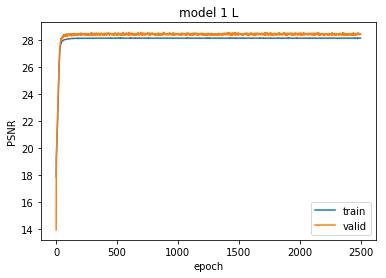

In [69]:
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['val_PSNR'])
plt.plot(np.arange(1, nb_epoch+1, 1), history.history['PSNR'])
plt.title('model 1 L')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.savefig("model 1-3/PSNR model 1-3.png")
plt.show()

In [20]:
layer = model.layers[0]
weights = layer.get_weights()
w = weights[0]
filter1 = Image.new(mode, (w.shape[0],w.shape[1]))
p1 = filter1.load()
for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        p1[i,j] = int(w[i][j][0][0]*255)
filter1.save('model 1-3/filter.png')

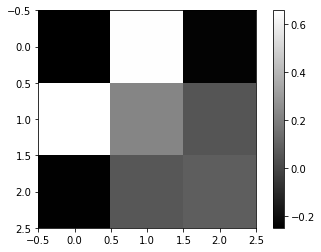

In [46]:
plt.imshow(w.squeeze(), cmap='gray')
plt.colorbar()
plt.savefig("model 1-3/filterplt.png")
plt.show()

In [47]:
model = load_model('model 1-3/model 1-3.h5', custom_objects={'PSNR': PSNR}) #если нужно выкачать модель

In [48]:
prediction = model.predict(in_test)
prediction5 = model.predict(in_test5)
prediction14 = model.predict(in_test14)

In [42]:
threecompare(in_test[0], out_test[0], prediction[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.74

Bicubic with laplasian image
SSIM: 0.73

Produced image
SSIM: 0.78


In [43]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction, img_rows, img_cols, 'all/with bias')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5, img_rows, img_cols, 'set5/with bias')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14, img_rows, img_cols, 'set14/with bias')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.6965971733
Laplasian PSNR: 27.0938131465
Model PSNR: 28.4269068015

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.3020557059
Laplasian PSNR: 30.4734484203
Model PSNR: 31.1517424438

Результаты для тестовой выборки Set14
Bicubic PSNR: 27.1266165964
Laplasian PSNR: 26.5595325701
Model PSNR: 27.9961423433


In [44]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.808942521008
Laplasian SSIM: 0.796779933914
Model SSIM: 0.847272451947

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.891099641769
Laplasian SSIM: 0.876578923455
Model SSIM: 0.917507049294

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.79595444677
Laplasian SSIM: 0.784164652479
Model SSIM: 0.836169188395


In [64]:
model1 = model

In [65]:
layer = model1.layers[0]
weights = layer.get_weights()
weights[1][0] = 0
layer.set_weights(weights)

In [66]:
prediction_1 = model1.predict(in_test)
prediction5_1 = model1.predict(in_test5)
prediction14_1 = model1.predict(in_test14)

In [30]:
threecompare(in_test[0], out_test[0], prediction_1[0])

Original image
SSIM: 1.00

Bicubic image
SSIM: 0.74

Bicubic with laplasian image
SSIM: 0.73

Produced image
SSIM: 0.78


In [31]:
print('Результаты для всей тестовой выборки')
results(in_test, out_test, prediction_1, img_rows, img_cols, 'all/without bias')

print('\n'+'Результаты для тестовой выборки Set5')
results(in_test5, out_test5, prediction5_1, img_rows, img_cols, 'set5/without bias')

print('\n'+'Результаты для тестовой выборки Set14')
results(in_test14, out_test14, prediction14_1, img_rows, img_cols, 'set14/without bias')

Результаты для всей тестовой выборки
Bicubic PSNR: 27.6965971733
Laplasian PSNR: 27.0938131465
Model PSNR: 28.4160311772

Результаты для тестовой выборки Set5
Bicubic PSNR: 31.3020557059
Laplasian PSNR: 30.4734484203
Model PSNR: 31.1379875445

Результаты для тестовой выборки Set14
Bicubic PSNR: 27.1266165964
Laplasian PSNR: 26.5595325701
Model PSNR: 27.9857218986


In [32]:
print('Результаты для всей тестовой выборки')
ressim(in_test, out_test, prediction_1, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set5')
ressim(in_test5, out_test5, prediction5_1, img_rows, img_cols)

print('\n'+'Результаты для тестовой выборки Set14')
ressim(in_test14, out_test14, prediction14_1, img_rows, img_cols)

Результаты для всей тестовой выборки
Bicubic SSIM: 0.808942521008
Laplasian SSIM: 0.796779933914
Model SSIM: 0.847243756002

Результаты для тестовой выборки Set5
Bicubic SSIM: 0.891099641769
Laplasian SSIM: 0.876578923455
Model SSIM: 0.917716912616

Результаты для тестовой выборки Set14
Bicubic SSIM: 0.79595444677
Laplasian SSIM: 0.784164652479
Model SSIM: 0.836102779037
